###   1. Hypothesis: We can derive an indication of AADT for local government roads from the Sample value in                      HERE historical data
-	Due by 6 November
-	New Austroads Guide to Temporary Traffic Management have a criteria to categorise state and local roads
-	Indication of AADT for local government roads (let’s say bands by 1000s) is desirable
-	Can the sample value in HERE historical data give us an indication of AADT?
-	Suggested approach/PoC – try to derive values from HERE by using a known AADT dataset


#### Load AADT 2018 data

In [1]:
import pandas as pd 
#Annual Average Daily Traffic (AADT) is the number of vehicles passing a point on a road in a 24 hour period averaged over a calendar year. This figure for short term counts is seasonally adjusted.
aadt_2018=pd.read_csv('trafficcensus2018.csv') #load from https://www.data.qld.gov.au/dataset/traffic-census-for-the-queensland-state-declared-road-network/resource/4b1011ec-61f1-4818-b44c-edfe15828a4e

### QA/QC  - check structure and for errors

In [2]:
aadt_2018.head()
aadt_2018.set_index('SITE_ID') 

,DESCRIPTION,LONGITUDE,LATITUDE,AADT,TDIST,PERCENT_HV,RSECT_ID,ROAD_NAME,TDIST_START,TDIST_END
SITE_ID,,,,,,,,,,
131646,Sth of Myora Res- Dunwich,153.411081,-27.482690,1942,2.500,13.25,1000,EAST COAST ROAD,0.000,9.360
131757,North of Beehive Rd,153.467567,-27.433770,1522,11.400,10.72,1000,EAST COAST ROAD,9.360,16.900
11412,80m south of Hillside Dve,153.233820,-27.732727,12134,0.500,22.26,1003,STAPYLTON - JACOBS WELL ROAD,0.000,1.090
12966,400m west of Quinns Rd,153.241597,-27.727702,8218,1.450,20.86,1003,STAPYLTON - JACOBS WELL ROAD,1.090,1.860
11754,600m east of Alberton Road,153.265828,-27.720495,4467,4.150,15.88,1003,STAPYLTON - JACOBS WELL ROAD,1.860,7.950
11543,At Behm Creek bridge,153.338545,-27.753331,1933,14.400,17.43,1003,STAPYLTON - JACOBS WELL ROAD,7.950,19.280
11548,Between Norman St & Scarborough St,153.410776,-27.961066,18753,0.150,8.88,101,SMITH STREET CONNECTION,0.000,0.480
11400,Between Kumbari Av & Parklands Dv,153.389276,-27.962996,51028,2.390,4.83,101,SMITH STREET CONNECTION,0.480,3.740
11545,1.5km west of Labrador-Carrara Rd Opass,153.361826,-27.962901,68524,5.200,3.27,101,SMITH STREET CONNECTION,3.740,7.400


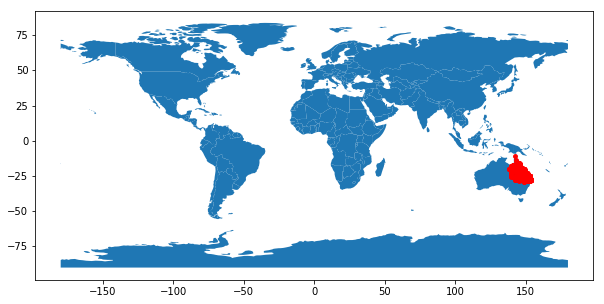

In [30]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
geometry = [Point(xy) for xy in zip(aadt_2018['LONGITUDE'],aadt_2018['LATITUDE'])]
aadt_2018_gdf = GeoDataFrame(aadt_2018, geometry=geometry)
aadt_2018_gdf.set_index('SITE_ID') 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
aadt_2018_gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

### Install leaflet - skip if not required.
Before using requests we need a proxy
Yesterday we downloaded the px proxy and copied it to your training folder.

In Windows explorer navigate to the folder that contains px
In the Windows explorer address bar type "cmd" to open a dos prompt in that folder
Run "px.exe" to start the proxy server

pip install --proxy=localhost:3128 mppleaflet

In [209]:
aadt_2018_gdf

,SITE_ID,DESCRIPTION,LONGITUDE,LATITUDE,AADT,TDIST,PERCENT_HV,RSECT_ID,ROAD_NAME,TDIST_START,TDIST_END,geometry
0,131646,Sth of Myora Res- Dunwich,153.411081,-27.482690,1942,2.500,13.25,1000,EAST COAST ROAD,0.000,9.360,POINT (153.4110807 -27.4826895)
1,131757,North of Beehive Rd,153.467567,-27.433770,1522,11.400,10.72,1000,EAST COAST ROAD,9.360,16.900,POINT (153.4675671 -27.43376999)
2,11412,80m south of Hillside Dve,153.233820,-27.732727,12134,0.500,22.26,1003,STAPYLTON - JACOBS WELL ROAD,0.000,1.090,POINT (153.2338199 -27.73272664)
3,12966,400m west of Quinns Rd,153.241597,-27.727702,8218,1.450,20.86,1003,STAPYLTON - JACOBS WELL ROAD,1.090,1.860,POINT (153.2415967 -27.72770231)
4,11754,600m east of Alberton Road,153.265828,-27.720495,4467,4.150,15.88,1003,STAPYLTON - JACOBS WELL ROAD,1.860,7.950,POINT (153.2658279 -27.72049471)
5,11543,At Behm Creek bridge,153.338545,-27.753331,1933,14.400,17.43,1003,STAPYLTON - JACOBS WELL ROAD,7.950,19.280,POINT (153.3385448 -27.75333082)
6,11548,Between Norman St & Scarborough St,153.410776,-27.961066,18753,0.150,8.88,101,SMITH STREET CONNECTION,0.000,0.480,POINT (153.4107765 -27.96106645)
7,11400,Between Kumbari Av & Parklands Dv,153.389276,-27.962996,51028,2.390,4.83,101,SMITH STREET CONNECTION,0.480,3.740,POINT (153.3892765 -27.9629959)
8,11545,1.5km west of Labrador-Carrara Rd Opass,153.361826,-27.962901,68524,5.200,3.27,101,SMITH STREET CONNECTION,3.740,7.400,POINT (153.3618256 -27.96290083)
9,11403,Between Sunlight Dr & Billabong Pl,153.436673,-28.101401,28192,2.200,5.63,102,BURLEIGH CONNECTION ROAD,0.000,3.300,POINT (153.4366728 -28.10140129)


In [31]:
import mplleaflet
import matplotlib.pyplot as plt

## Size limitation displaying over 1000 points
## len(aadt_2018_gdf) shows 2218 = missing 1218 points over half
lons= aadt_2018_gdf['LONGITUDE'][0:1000].values.tolist()
lats= aadt_2018_gdf['LATITUDE'][0:1000].values.tolist()

fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'r.')

#And after this call the funtion:
mplleaflet.display(fig=fig,)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000424F4D68>]],
      dtype=object)

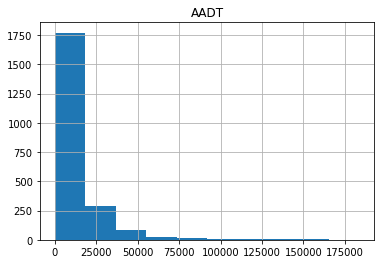

In [247]:
aadt_2018_gdf.hist('AADT') #Shows the count/frequency of counts - shows the majority of counts belwo 25000

In [268]:
aadt_2018_gdf['AADT'].describe().round()

count      2218.0
mean      11731.0
std       20398.0
min           0.0
25%         772.0
50%        3840.0
75%       14179.0
max      183592.0
Name: AADT, dtype: float64

In [330]:
aadt_2018_gdf_sort= aadt_2018_gdf.sort_values(by='AADT', ascending=False)
top_aadt_2018_gdf_sort=aadt_2018_gdf_sort[3:4] #top five aadt values
top_aadt_2018_gdf_sort

,SITE_ID,DESCRIPTION,LONGITUDE,LATITUDE,AADT,TDIST,PERCENT_HV,RSECT_ID,ROAD_NAME,TDIST_START,TDIST_END,geometry
2146,135970,Pine River Bridge,153.018231,-27.294103,155916,14.05,11.39,U14,GYMPIE ARTERIAL ROAD,13.5,14.31,POINT (153.0182314 -27.29410263)


### Below code for automating identification PVids from HERE

Return HERE PVIDS
prox=lat,lon,radius .../6.2/reversegeocode.{format}?=...

https://reverse.geocoder.api.here.com/6.2/reversegeocode.{format} https://developer.here.com/documentation/geocoder/topics/resources.html

In [9]:
#Set session proxies
import requests
import time
session = requests.Session()  # think of this as a new browser tab
session.proxies = {
    'http': 'localhost:3128',
    'https': 'localhost:3128'
}
#session.get('https://www.tmr.qld.gov.au')

In [173]:
import json
#location='-27.294103,153.018231' #AADT site counter, this needs to be parsed
loc_lat=-27.294103#   -27.732727
loc_long=153.018231#   153.233820

location=str(loc_lat)+','+str(loc_long)
prox='10'

#creditials load
data=pd.read_json("credentials.json")
app_id=data['credentials'][0]['appid']
app_code=data['credentials'][0]['appcode']
            
url = "https://reverse.geocoder.api.here.com/6.2/reversegeocode.json"
url +="?app_id="+app_id+"&app_code="+app_code
#url +="&mode=retrieveAddresses&maxresults=1&additionaldata=IncludeShapeLevel%2CpostalCode" #if you want the areas searched
url +="&mode=retrieveAddresses&maxresults=1"
url +="&locationattributes=mapReference"
url +="&prox="+location+','+prox

response = session.get(url)
response_json = response.json()

here_link=response_json['Response']['View'][0]['Result'][0]['Location']['MapReference']['ReferenceId'] #PVids
here_link_street=response_json['Response']['View'][0]['Result'][0]['Location']['Address']['Street'] # name 3
pvid_x=response_json['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']
pvid_y=response_json['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude']

In [180]:
#distance calculation
import math
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c *1000

    return round(d,1)

distance_between_aadtsite_and_here_links = distance((loc_lat, loc_long), (pvid_y, pvid_x))
#so if above > say 50m - no use checking?

print(str(distance_between_aadtsite_and_here_links)+ ' metres') 

0.2 metres


In [175]:
location_x =[loc_long,pvid_x]
location_y =[loc_lat,pvid_y]
location_x,location_y

#Show location of return HERE PVids
fig = plt.figure(figsize=(12,12))    #This is missing in your code.
plt.plot(location_x,location_y, 'rx',ms = 14)
mplleaflet.display(fig=fig,)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [15]:
import mplleaflet
import matplotlib.pyplot as plt

## Size limitation displaying over 1000 points
## len(aadt_2018_gdf) shows 2218 = missing 1218 points over half
lons= aadt_2018_gdf['LONGITUDE'][0:1000].values.tolist()
lats= aadt_2018_gdf['LATITUDE'][0:1000].values.tolist()

fig = plt.figure(figsize=(8, 8))    #This is missing in your code.
plt.plot(lons, lats, 'r.')

#And after this call the funtion:
mplleaflet.display(fig=fig,)

[{'_type': 'SearchResultsViewType',
  'ViewId': 0,
  'Result': [{'Relevance': 1.0,
    'Distance': 4.3,
    'MatchLevel': 'houseNumber',
    'MatchQuality': {'Country': 1.0,
     'State': 1.0,
     'City': 1.0,
     'District': 1.0,
     'Street': [1.0],
     'HouseNumber': 1.0,
     'PostalCode': 1.0},
    'MatchType': 'interpolated',
    'Location': {'LocationId': 'NT_Hn4n2Q187zjJ3bkz-hdDiB_l_784327237_R_xQzM',
     'LocationType': 'point',
     'DisplayPosition': {'Latitude': -26.7020725, 'Longitude': 153.1294375},
     'MapView': {'TopLeft': {'Latitude': -26.7009483,
       'Longitude': 153.1281792},
      'BottomRight': {'Latitude': -26.7031966, 'Longitude': 153.1306959}},
     'Address': {'Label': '143 Point Cartwright Dr, Buddina QLD 4575, Australia',
      'Country': 'AUS',
      'State': 'QLD',
      'City': 'Sunshine Coast',
      'District': 'Buddina',
      'Street': 'Point Cartwright Dr',
      'HouseNumber': '143',
      'PostalCode': '4575',
      'AdditionalData': [{'va

### Given meets minimum criteria - check HERE route historic 2018/01/01 - 2018/12/31

TODO: Need to write automated api call here --- currently sending request via GUI

In [427]:
here_links=pd.read_csv('HERE_DA_40074_00000.csv') 

In [428]:
here_links.head()

,LINK-DIR,DATE-TIME,EPOCH-60MIN,LENGTH,COUNT,MEAN,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1212846345F,1/01/2018 10:00,10,64,30,97.4,NaN,NaN,NaN,NaN
1,1212846345F,1/01/2018 11:00,11,64,22,96.4,NaN,NaN,NaN,NaN
2,1212846345F,1/01/2018 12:00,12,64,16,93.0,NaN,NaN,NaN,NaN
3,1212846345F,1/01/2018 13:00,13,64,14,93.1,NaN,NaN,NaN,NaN
4,1212846345F,1/01/2018 14:00,14,64,21,97.7,NaN,NaN,NaN,NaN


In [429]:
here_links_rel_col = here_links[['DATE-TIME','EPOCH-60MIN','COUNT']] #save only the columns needed
here_links_rel_col['DATE-TIME']= pd.to_datetime(here_links_rel_col['DATE-TIME'],dayfirst=True) #set date/time column as time type
#here_links_rel_col=here_links_rel_col.set_index('DATE-TIME')

#set weekday names
here_links_rel_col['DATE-TIME'] = pd.to_datetime(here_links_rel_col['DATE-TIME'])
here_links_rel_col['day_of_week'] = here_links_rel_col['DATE-TIME'].dt.day_name()
#here_links_rel_col.dtypes
here_links_rel_col.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

,DATE-TIME,EPOCH-60MIN,COUNT,day_of_week
8596,2018-12-31 19:00:00,19,9,Monday
8597,2018-12-31 20:00:00,20,5,Monday
8598,2018-12-31 21:00:00,21,10,Monday
8599,2018-12-31 22:00:00,22,3,Monday
8600,2018-12-31 23:00:00,23,6,Monday


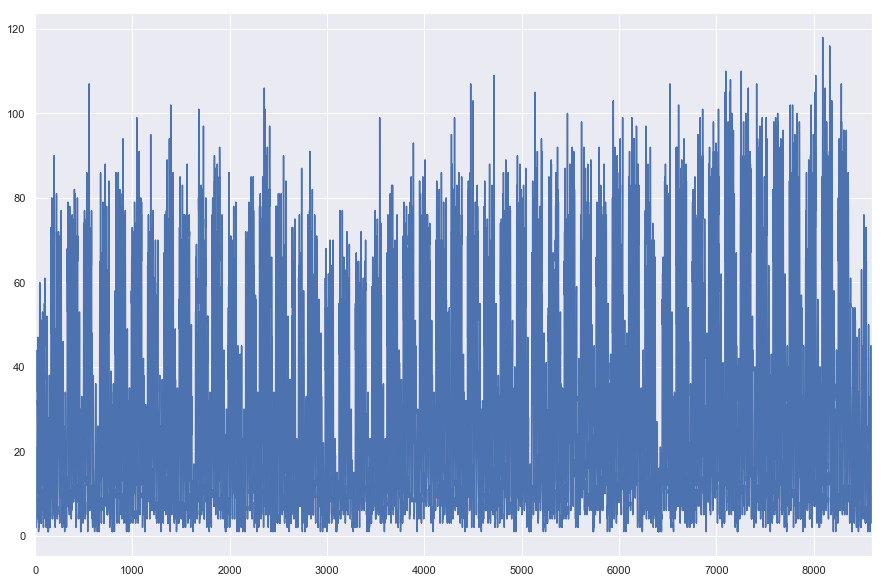

In [433]:
here_links_rel_col.dtypes
#here_links_rel_col=here_links_rel_col.set_index('DATE-TIME')
here_links_rel_col['COUNT'].plot(figsize=(15,10))

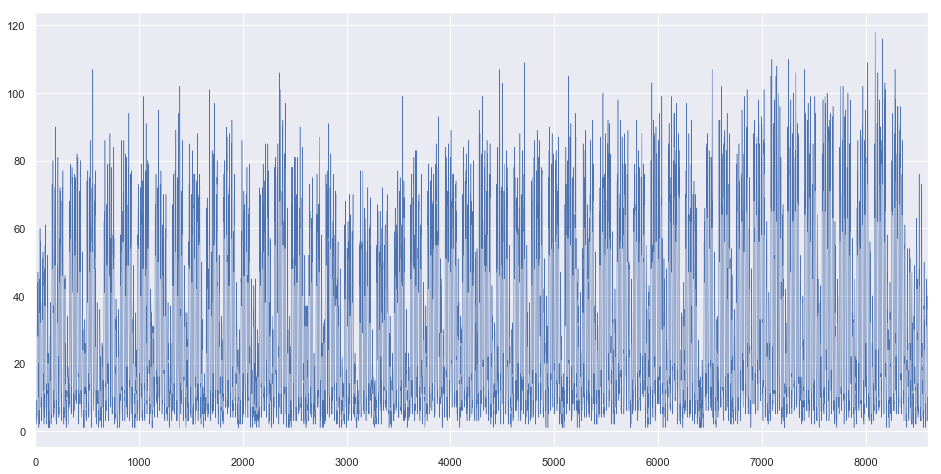

In [435]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16, 8)})
here_links_rel_col['COUNT'].plot(linewidth=0.5);

#cols_plot = ['COUNT']
#axes = here_links_rel_col[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
#for ax in axes:
#    ax.set_ylabel('Counts')

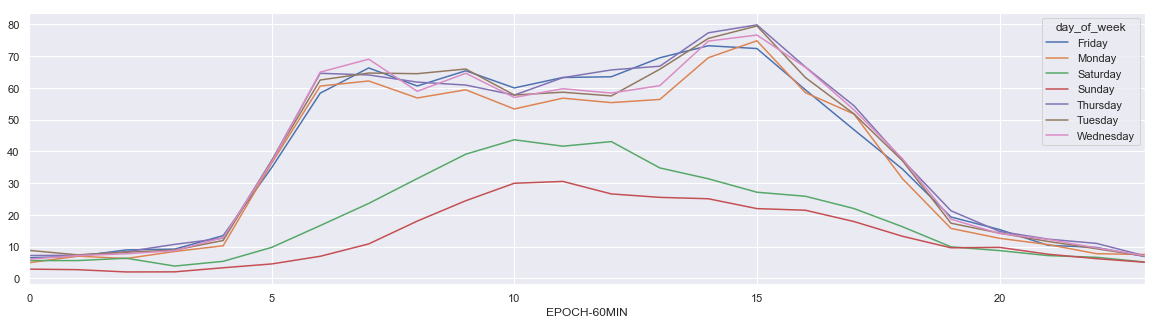

In [437]:
#average day of week
here_links_rel_col.pivot_table(
    index = 'EPOCH-60MIN',
    columns ='day_of_week',
    values = 'COUNT',   aggfunc='mean', fill_value=0).plot(subplots=False, figsize=(20, 5), grid= True);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


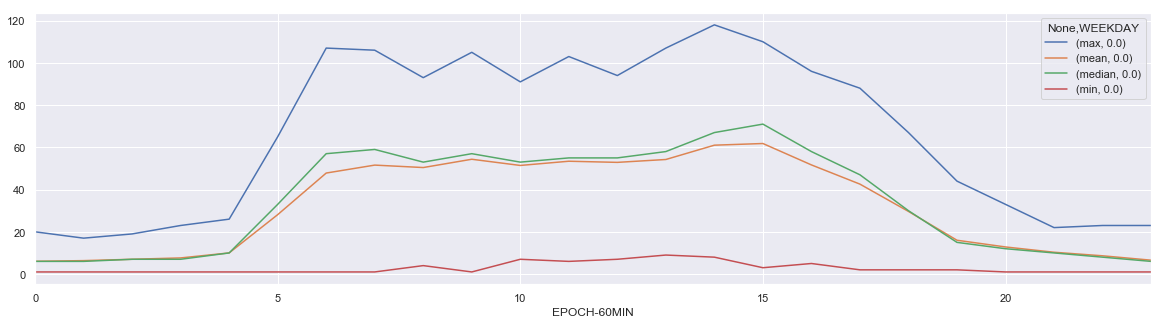

In [446]:
# just weekdays statistics
here_links_rel_col['WEEKDAY'] = ((pd.DatetimeIndex(here_links_rel_col.index).dayofweek) // 5 == 1).astype(float)
mask = here_links_rel_col['WEEKDAY'] == 0
here_links_rel_col_weekdays = here_links_rel_col.loc[mask]

here_links_rel_col_weekdays.pivot_table(
    index = 'EPOCH-60MIN',
    columns ='WEEKDAY',
    values = 'COUNT',   aggfunc=('max','median','mean','min'), fill_value=0).plot(subplots=False, figsize=(20, 5), grid= True);

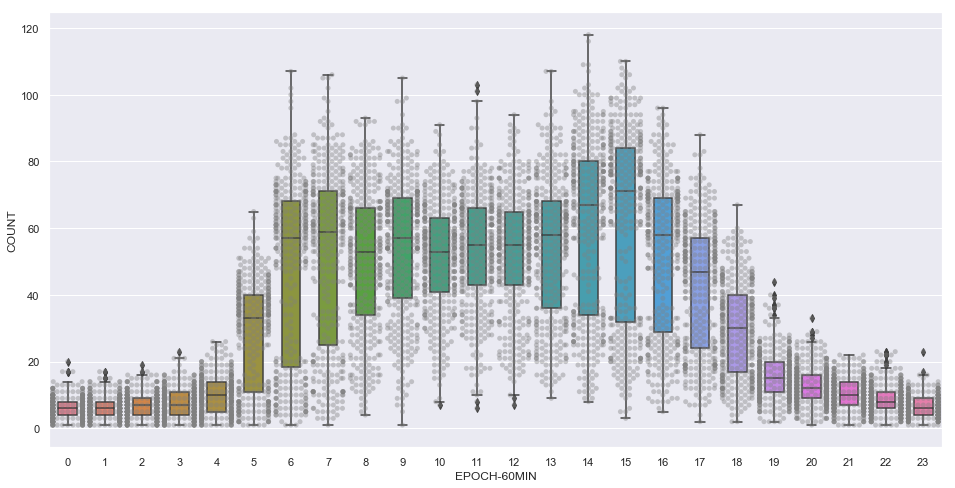

In [458]:
#shows distribution on weekday count
bplot=sns.boxplot(y='COUNT', x='EPOCH-60MIN', 
                 data=here_links_rel_col_weekdays, 
                 width=0.5,
                 palette="husl")

# add swarmplot
bplot=sns.swarmplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              color='grey',
              alpha=0.4)


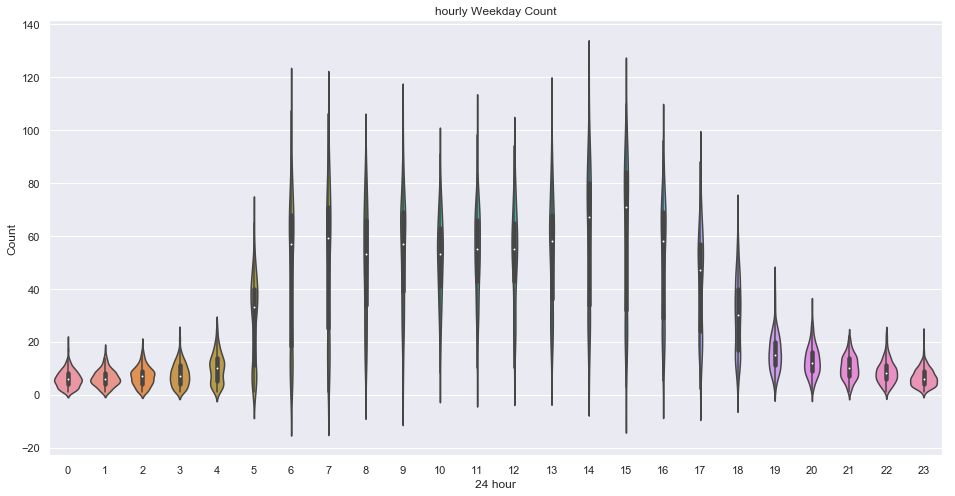

In [465]:
# add violin plot
fig, axes = plt.subplots()
sns.violinplot(y='COUNT', x='EPOCH-60MIN',
              data=here_links_rel_col_weekdays, 
              alpha=0.4)
axes.set_title('hourly Weekday Count')
axes.set_xlabel('24 hour')
axes.set_ylabel('Count')

plt.show()

DATE-TIME      datetime64[ns]
EPOCH-60MIN             int64
COUNT                   int64
day_of_week            object
WEEKDAY               float64
dtype: object

,EPOCH-60MIN,COUNT,day_of_week
DATE-TIME,,,
2018-01-01 10:00:00,10,30,Monday
2018-01-01 11:00:00,11,22,Monday
2018-01-01 12:00:00,12,16,Monday
2018-01-01 13:00:00,13,14,Monday
2018-01-01 14:00:00,14,21,Monday
2018-01-01 15:00:00,15,21,Monday
2018-01-01 16:00:00,16,13,Monday
2018-01-01 17:00:00,17,8,Monday
2018-01-01 18:00:00,18,8,Monday


,EPOCH-60MIN,COUNT,day_of_week,WEEKEND
DATE-TIME,,,,
2018-01-01 10:00:00,10,30,Monday,0
2018-01-01 11:00:00,11,22,Monday,0
2018-01-01 12:00:00,12,16,Monday,0
2018-01-01 13:00:00,13,14,Monday,0
2018-01-01 14:00:00,14,21,Monday,0
2018-01-01 15:00:00,15,21,Monday,0
2018-01-01 16:00:00,16,13,Monday,0
2018-01-01 17:00:00,17,8,Monday,0
2018-01-01 18:00:00,18,8,Monday,0


,EPOCH-60MIN,COUNT,day_of_week,WEEKEND
DATE-TIME,,,,
2018-01-01 10:00:00,10,30,Monday,0
2018-01-01 11:00:00,11,22,Monday,0
2018-01-01 12:00:00,12,16,Monday,0
2018-01-01 13:00:00,13,14,Monday,0
2018-01-01 14:00:00,14,21,Monday,0
2018-01-01 15:00:00,15,21,Monday,0
2018-01-01 16:00:00,16,13,Monday,0
2018-01-01 17:00:00,17,8,Monday,0
2018-01-01 18:00:00,18,8,Monday,0
